## Plot importances

Plot the importances of the features used in classification

### Files Needed:
1. Positions features as a csv

### Instructions:
Run cells in order

In [9]:
%matplotlib inline
import pandas as pd
import numpy as np
import pickle
from collections import defaultdict

# Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier

# CV Splitting
import random as random
from sklearn.model_selection import StratifiedKFold
from sklearn.datasets import make_classification
from sklearn.cross_validation import KFold
from sklearn.preprocessing import scale

# Evaluation
from sklearn.metrics import roc_curve, auc, precision_recall_curve,average_precision_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest

# Plotting
import matplotlib.pyplot as plt
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

# Downsamplers imports - prototype selection - controlled
from imblearn.under_sampling import RandomUnderSampler

from IPython.core.display import HTML
HTML("<style>.container { width:100% !important; }</style>")

### Reading the input dataset

In [2]:
curr_dir = !pwd
input_path = curr_dir[0]+"/../../10.Prediction/domains_similarity/filtered_features_table/"
filename = "positions_features_mediode_filter_01.25.18.csv"
bind_scores_num = 10

features_all = pd.read_csv(input_path+filename, sep='\t', index_col=0)
features_cols = features_all.columns[1:-bind_scores_num] #removing binding scores and domain name
ligands = ["dna", "dnabase", "dnabackbone", "rna", "rnabase", "rnabackbone", "peptide", "ion", "metabolite"]

classifiers = {}
classifiers["Logistic"] = LogisticRegression(C=0.001, random_state=0)
classifiers["RF"] = RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=0)
#classifiers["KNN"] = KNeighborsClassifier(n_neighbors=100, n_jobs=-1)
#classifiers["SVM"] = SVC(kernel='rbf', probability=True, random_state=0)
classifiers["ADA"] = AdaBoostClassifier(n_estimators=1000, random_state=0)
classifiers["XGB"] = XGBClassifier(n_estimators=1000, n_jobs=-1, random_state=0, max_depth=6, min_child_weight=0.05, colsample_bytree=0.5)

### Datasets of negative examples

In [3]:
non_binding_positions = features_all[features_all["max_binding_score"] == 0]
non_binding_positions = non_binding_positions.loc[:,features_cols]
print "non_binding #: "+str(non_binding_positions.shape[0])

non_binding #: 27191


In [5]:
with open(curr_dir[0]+"/../ligands_negatives_domains_dict.pik", 'rb') as handle:
    negatives_dict = pickle.load(handle)

ligands_negatives_df = {}
for ligand in ligands:
    ligands_negatives_df[ligand] = pd.DataFrame()
    for domain in negatives_dict[ligand]:
        if domain == 'negatives' or domain == 'domains':
            continue
        domain_all = features_all.loc[features_all.loc[:,"domain_name"] == domain,:]
        if len(domain_all) == 0:
            continue
        ligands_negatives_df[ligand] = pd.concat([ligands_negatives_df[ligand],domain_all.loc[domain_all.loc[:,"max_binding_score"] == 0,:]])
    
    ligands_negatives_df[ligand] = ligands_negatives_df[ligand][features_cols]
    print(ligand+" non-binding #: "+str(len(ligands_negatives_df[ligand])))

dna non-binding #: 1531
dnabase non-binding #: 1219
dnabackbone non-binding #: 1515
rna non-binding #: 1343
rnabase non-binding #: 1309
rnabackbone non-binding #: 1331
peptide non-binding #: 8142
ion non-binding #: 20351
metabolite non-binding #: 16143


### Datasets of positive examples by ligand

In [6]:
bind_th = 0.1
ligands_features_df = {}

for ligand in ligands:
    score_col_str = ligand+"_binding_score"
    ligand_binding_df = features_all[features_all[score_col_str] >= bind_th]
    ligands_features_df[ligand] = ligand_binding_df.loc[:,features_cols]

### Test features and create ranking

In [10]:
# List of features
features_list = np.array([c.encode('ascii','ignore') for c in ligands_features_df['dna'].columns])
# Rankings by ligand/test
ranking = defaultdict(list)

for ligand in ligands:
    # Down-sample
    X = pd.concat([ligands_features_df[ligand], non_binding_positions])
    y = [1] * ligands_features_df[ligand].shape[0]
    y.extend([0] * non_binding_positions.shape[0])
    y = np.array(y)
    X_sampled, y_sampled = RandomUnderSampler(random_state=0).fit_sample(X, y)
    
    # Feature selection models
    var_model = VarianceThreshold(threshold=(.3)).fit(X_sampled,y_sampled)
    kbest_model = SelectKBest(k=200).fit(X_sampled,y_sampled)
    trees_model = ExtraTreesClassifier().fit(X_sampled,y_sampled)

    # Extract feature scores and remove NaNs
    # Variances for var; ANOVA f-value for kbest; Relative importances for trees
    var = np.asarray(var_model.variances_)
    var[np.isnan(var)] = -1
    kbest = np.asarray(kbest_model.scores_)
    kbest[np.isnan(kbest)] = -1
    trees = np.asarray(trees_model.feature_importances_)
    trees[np.isnan(trees)] = -1

    # Create ranking
    ranking[ligand+"_var"] = features_list[np.argsort(var)][::-1]
    ranking[ligand+"_kbest"] = features_list[np.argsort(kbest)][::-1]
    ranking[ligand+"_trees"] = features_list[np.argsort(trees)][::-1]

//anaconda/envs/py27/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning:

Features [186 207 346 347 348 349] are constant.

//anaconda/envs/py27/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning:

Features [  7 186 207 346 347 348 349] are constant.



### Plot top 10 features ranked by RF for two classes of negatives (max binding score is 0)

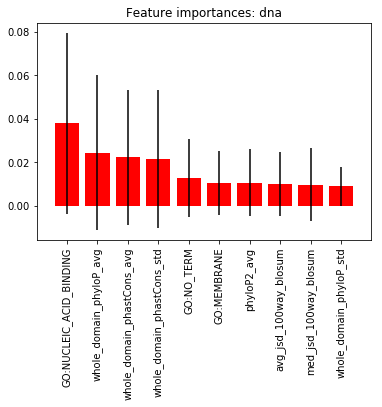

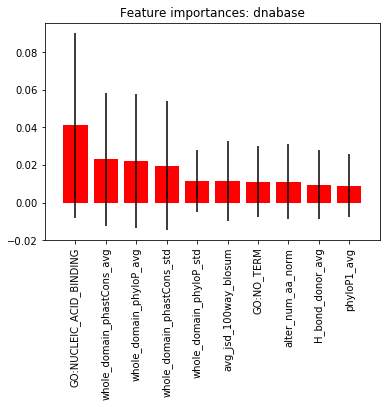

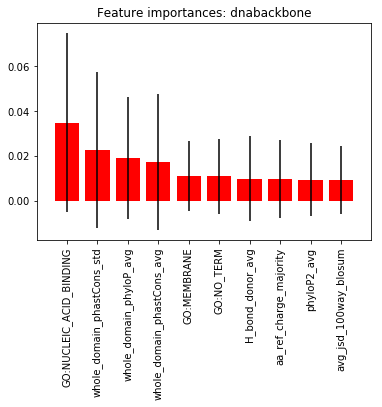

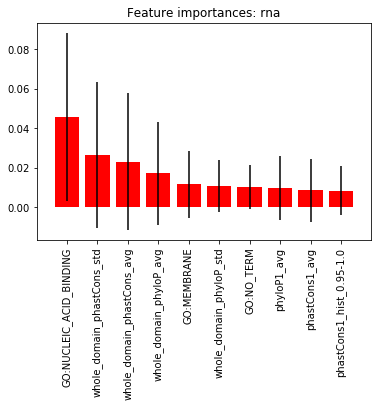

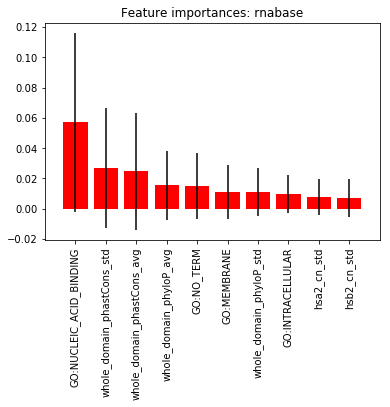

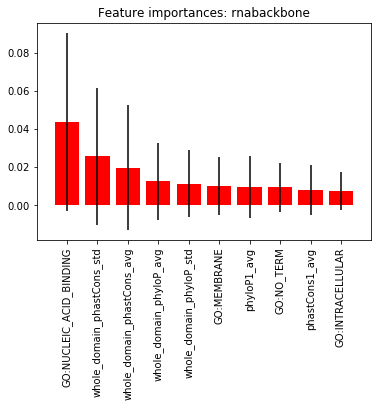

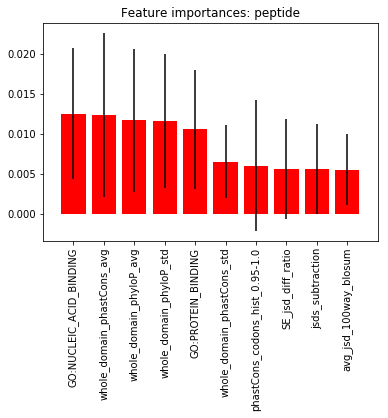

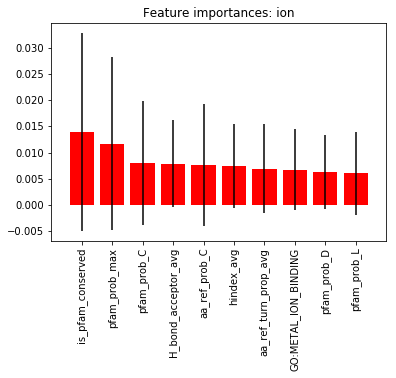

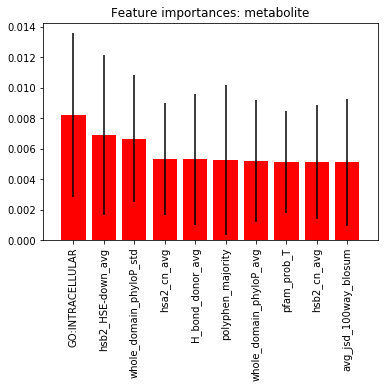

In [11]:
## Ligand negatives only from domains with at least one ligand binding position

features_list = np.array([c.encode('ascii','ignore') for c in ligands_features_df['dna'].columns])
# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,random_state=0)
for ligand in ligands:
    # Sample positives and negatives
    X = pd.concat([ligands_features_df[ligand], non_binding_positions])
    y = [1] * ligands_features_df[ligand].shape[0]
    y.extend([0] * non_binding_positions.shape[0])
    y = np.array(y)
    X_sampled, y_sampled = RandomUnderSampler(random_state=0).fit_sample(X, y)
    
    forest.fit(X_sampled, y_sampled)
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances: "+ligand)
    plt.bar(range(10), importances[indices][0:10],
           color="r", yerr=std[indices][0:10], align="center")
    plt.xticks(range(10), features_list[indices][0:10], rotation=90)
    plt.xlim([-1, 10])
    plt.show()

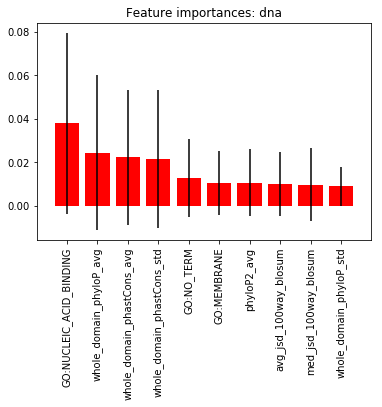

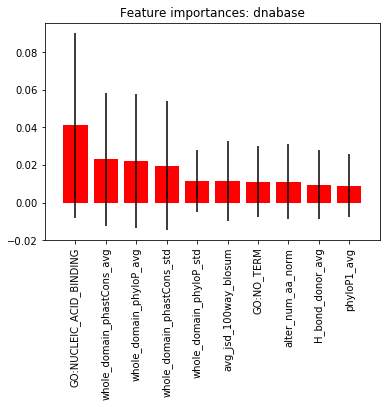

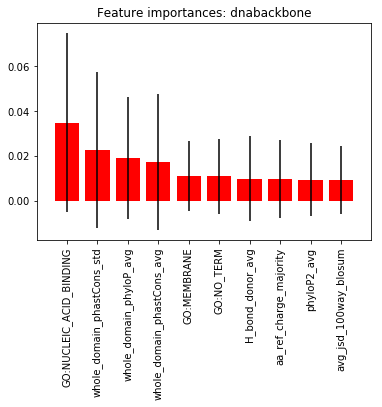

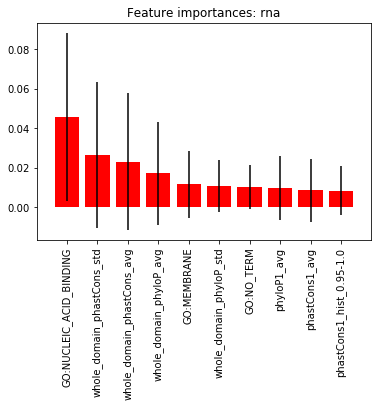

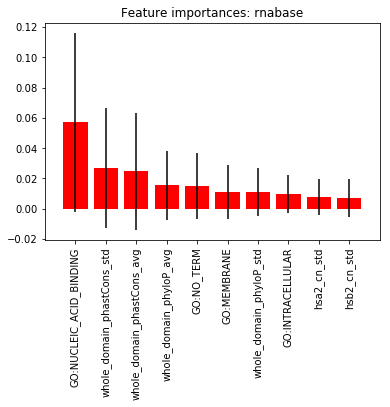

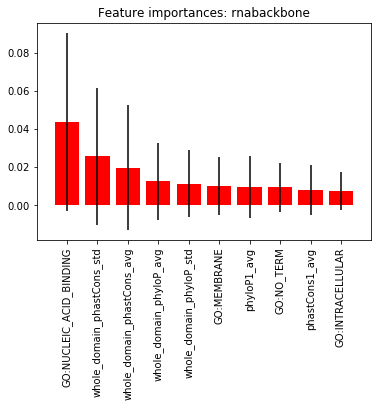

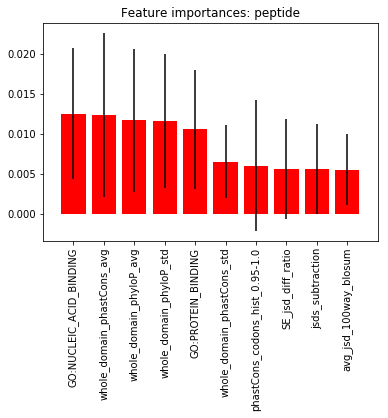

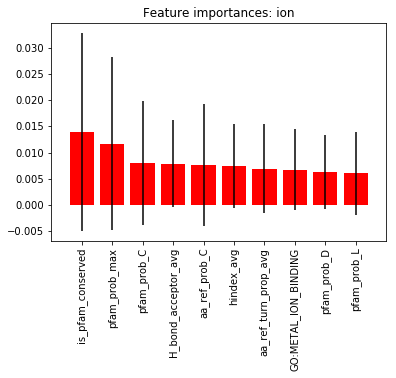

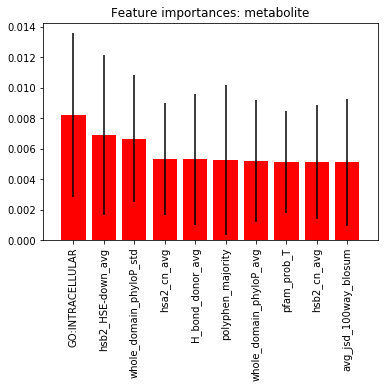

In [12]:
## Negatives from all domains

features_list = np.array([c.encode('ascii','ignore') for c in ligands_features_df['dna'].columns])
# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,random_state=0)
for ligand in ligands:
    # Sample positives and negatives
    X = pd.concat([ligands_features_df[ligand], non_binding_positions])
    y = [1] * ligands_features_df[ligand].shape[0]
    y.extend([0] * non_binding_positions.shape[0])
    y = np.array(y)
    X_sampled, y_sampled = RandomUnderSampler(random_state=0).fit_sample(X, y)
    
    forest.fit(X_sampled, y_sampled)
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances: "+ligand)
    plt.bar(range(10), importances[indices][0:10],
           color="r", yerr=std[indices][0:10], align="center")
    plt.xticks(range(10), features_list[indices][0:10], rotation=90)
    plt.xlim([-1, 10])
    plt.show()